In [1]:
import ROOT
import numpy as np
import os 
import copy

Welcome to JupyROOT 6.22/06


In [2]:
pion_pair=[211,111]

pid_str_1 = str(pion_pair[0]).replace("-211","piminus").replace("211","piplus").replace("111","pi0")
pid_str_2 = str(pion_pair[1]).replace("-211","piminus").replace("211","piplus").replace("111","pi0")

dihadron_str = f"{pid_str_1}_{pid_str_2}"

tfile1 = ROOT.TFile(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/clas12_dihadrons/projects/pipi0_paper_RGA_only/asym/MC_RGA_inbending/precut/{dihadron_str}/Mh/AZI/outsPlotBins/DataWeightedTree.root")
tfile2 = ROOT.TFile(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/clas12_dihadrons/projects/pipi0_paper_RGA_only/asym/Fall2018Spring2019_RGA_inbending/precut/{dihadron_str}/Mh/AZI/outsPlotBins/DataWeightedTree.root")

tmc=tfile1.Get("dihadron_cuts") # Monte Carlo TTree
tdata=tfile2.Get("dihadron_cuts") # Data TTree


In [3]:
import yaml

def get_binning_structure(index):
    file_path = '/work/clas12/users/gmat/clas12/clas12_dihadrons/utils/binning_files/Binning_1d_only.yaml'
    # Load the YAML file
    with open(file_path, 'r') as file:
        data = yaml.safe_load(file)

    # Extract dimensionNames and binEdges
    binning_structures = data.get('binningStructures', [])
    if index < len(binning_structures):
        binning_structure = binning_structures[index]
        dimension_names = binning_structure.get('dimensionNames', [])
        bin_edges = binning_structure.get('binEdges', [])

        return dimension_names, bin_edges

    # Return None if the index is out of range
    return None

In [4]:

def canvas_sweight_vs_monte_carlo(branch_name, xtitle, xmin, xmax, nbins):
    # Create a canvas
    c = ROOT.TCanvas("c", "Histograms", 600, 600)



    # Draw the data histogram
    tdata.Draw(f"{branch_name}>>data_hist({nbins}, {xmin}, {xmax})", "Signal", "E1", N)
    data_hist = ROOT.gPad.GetPrimitive("data_hist")
    data_hist.SetMarkerColor(ROOT.kRed)
    data_hist.SetLineColor(ROOT.kRed)
    data_hist.SetMarkerStyle(22)
    ROOT.gStyle.SetErrorX(0)
    data_hist.SetTitle("")
    data_hist.GetXaxis().SetTitleSize(0.05)
    data_hist.GetXaxis().SetTitle(xtitle)
    data_hist.GetYaxis().SetTitle("Counts")
    data_hist.SetStats(False)
    ROOT.gPad.SetLeftMargin(0.15)
    ROOT.gPad.SetBottomMargin(0.15)
    
    # Draw the MC histogram
    tmc.Draw(f"{branch_name}>>mc_hist({nbins}, {xmin}, {xmax})", "Signal", "E1 same", N)
    mc_hist = ROOT.gPad.GetPrimitive("mc_hist")
    mc_hist.SetMarkerColor(ROOT.kBlue)
    mc_hist.SetLineColor(ROOT.kBlue)
    mc_hist.SetMarkerStyle(23)
    mc_hist.SetStats(False)

    # Draw the legend
    legend = ROOT.TLegend(0.5, 0.75, 0.85, 0.85)
    legend.AddEntry(data_hist, "sWeighted Data", "pe")
    legend.AddEntry(mc_hist, "True Monte Carlo", "pe")
    legend.SetBorderSize(1)
    legend.Draw()

    data_hist.Scale(mc_hist.Integral() / data_hist.Integral())
    ymax = np.amax([data_hist.GetMaximum(), mc_hist.GetMaximum()])
    data_hist.GetYaxis().SetRangeUser(0, ymax * 1.2)
    
    # Set tick marks on the top and right sides
    ROOT.gPad.SetTickx(1)
    ROOT.gPad.SetTicky(1)

    # Return a deepcopy of the canvas
    return copy.deepcopy(c)

In [5]:
def canvas_with_ratio(branch_name, xtitle, xmin, xmax, nbins, cut="1",ratio_y_scale=[0.3,1.7]):
    # Parameters
    upper_pad_ratio = 0.65
    lower_pad_ratio = 0.35
    upper_pad_ytitle = ""
    lower_pad_ytitle = "Data/MC"
    lower_pad_yrange = (0.5, 1.5)

    # Create a canvas
    c = ROOT.TCanvas("c", "Histograms", 600, 600)

    # Create the upper pad for histograms
    pad_upper = ROOT.TPad("pad_upper", "pad_upper", 0, lower_pad_ratio, 1, 1)
    pad_upper.SetBottomMargin(0.00)
    pad_upper.SetLeftMargin(0.15)
    pad_upper.Draw()
    pad_upper.cd()

    # Draw the data histogram
    tdata.Draw(f"{branch_name}>>data_hist({nbins}, {xmin}, {xmax})", f"Signal * {cut}", "E1", N)
    data_hist = ROOT.gPad.GetPrimitive("data_hist")
    data_hist.SetMarkerColor(ROOT.kRed)
    data_hist.SetLineColor(ROOT.kRed)
    data_hist.SetMarkerStyle(22)
    ROOT.gStyle.SetErrorX(0)
    data_hist.SetTitle("")
    data_hist.GetXaxis().SetTitleSize(0.05)
    data_hist.GetYaxis().SetNdivisions(508)
    data_hist.GetYaxis().SetTitleOffset(0.95)
    data_hist.GetXaxis().SetTitle(xtitle)
    data_hist.GetYaxis().SetTitle(upper_pad_ytitle)
    data_hist.GetYaxis().SetTitleSize(0.045 * (1 / upper_pad_ratio))
    data_hist.GetYaxis().SetLabelSize(0.04 * (1 / upper_pad_ratio))
    
    data_hist.SetStats(False)

    # Draw the MC histogram
    tmc.Draw(f"{branch_name}>>mc_hist({nbins}, {xmin}, {xmax})", f"trueparentpid_2==111&&{cut}", "E1 same", N)
    mc_hist = ROOT.gPad.GetPrimitive("mc_hist")
    mc_hist.SetMarkerColor(ROOT.kBlue)
    mc_hist.SetLineColor(ROOT.kBlue)
    mc_hist.SetMarkerStyle(23)
    mc_hist.SetStats(False)

    # Draw the legend
    legend = ROOT.TLegend(0.5, 0.7, 0.85, 0.85)
    legend.AddEntry(data_hist, "sWeighted Data", "pe")
    legend.AddEntry(mc_hist, "True Monte Carlo", "pe")
    legend.SetBorderSize(1)
    legend.Draw()

    try:
        data_hist.Scale(mc_hist.Integral() / data_hist.Integral())
    except:
        return 0
    ymax = np.amax([data_hist.GetMaximum(), mc_hist.GetMaximum()])
    data_hist.GetYaxis().SetRangeUser(0.0001, ymax * 1.2)

    # Set tick marks on the top and right sides
    ROOT.gPad.SetTickx(1)
    ROOT.gPad.SetTicky(1)

    c.cd()
    # Create the lower pad for ratio
    pad_lower = ROOT.TPad("pad_lower", "pad_lower", 0, 0, 1, lower_pad_ratio)
    pad_lower.SetTopMargin(0.00)
    pad_lower.SetBottomMargin(0.4)
    pad_lower.SetLeftMargin(0.15)
    pad_lower.Draw()
    pad_lower.cd()

    # Calculate the ratio
    ratio_hist = copy.deepcopy(data_hist)
    ratio_hist.Divide(mc_hist)

    # Set the ratio plot attributes
    ratio_hist.SetMarkerStyle(20)
    ratio_hist.SetMarkerColor(ROOT.kBlack)
    ratio_hist.SetLineColor(ROOT.kBlack)
    ratio_hist.GetYaxis().SetTitle(lower_pad_ytitle)
    ratio_hist.GetYaxis().SetNdivisions(503)
    ratio_hist.GetYaxis().SetTitleSize(0.05 * (1 / lower_pad_ratio))
    ratio_hist.GetYaxis().SetLabelSize(0.04 * (1 / lower_pad_ratio))
    ratio_hist.GetXaxis().SetTitleSize(0.06 * (1 / lower_pad_ratio))
    ratio_hist.GetXaxis().SetLabelSize(0.04 * (1 / lower_pad_ratio))
    ratio_hist.GetYaxis().SetRangeUser(ratio_y_scale[0],ratio_y_scale[1])

    # Draw the ratio plot
    ratio_hist.Draw("E1")

    # Draw a dotted horizontal line at y=0
    line = ROOT.TLine(ratio_hist.GetXaxis().GetXmin(), 1, ratio_hist.GetXaxis().GetXmax(), 1)
    line.SetLineStyle(2)
    line.Draw("same")
    
    # Return a deepcopy of the canvas
    return copy.deepcopy(c)

In [6]:
def do_grid_canvas(branch_name, xtitle, xmin, xmax, nbins, cut_variable, cut_bins,ratio_y_scale=[0.3,1.7]):

    # For each cut, create a canvas and draw it in the appropriate pad
    for i in range(n_cuts):
        # Define the cut
        cut = f"{cut_variable} > {cut_bins[i]} && {cut_variable} <= {cut_bins[i+1]}"
        cut_name = f"{cut_variable} #in ({cut_bins[i]:.3f}, {cut_bins[i+1]:.3f})"

        # Create the canvas for this cut
        #c_list.append( canvas_with_ratio(branch_name, xtitle, xmin, xmax, nbins, cut) )
        c = canvas_with_ratio(branch_name, xtitle, xmin, xmax, nbins, cut,ratio_y_scale) 
        cc.append(copy.deepcopy(c))
        
        # Add a title to the pad
        pad_list.append(ROOT.TPaveLabel(0.15, 0.94, 0.9, 0.98, cut_name))
        pad_list[-1].SetFillColor(ROOT.kWhite)



In [7]:
N=int(1e6)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


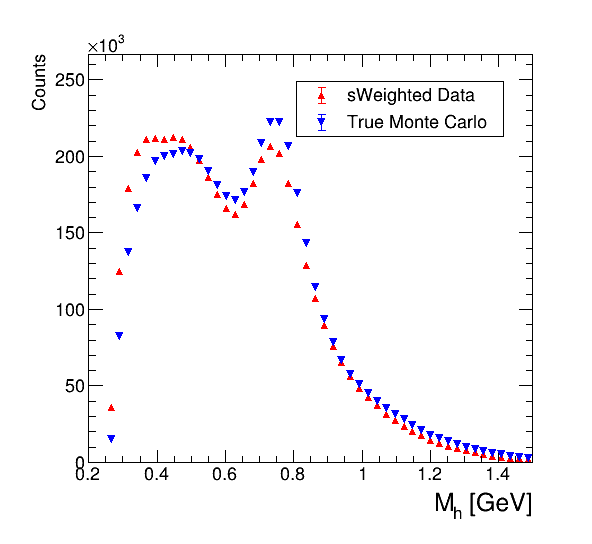

In [10]:
canvas = canvas_sweight_vs_monte_carlo("Mh", "M_{h} [GeV]", 0.2, 1.5, 50)
canvas.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: cc
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


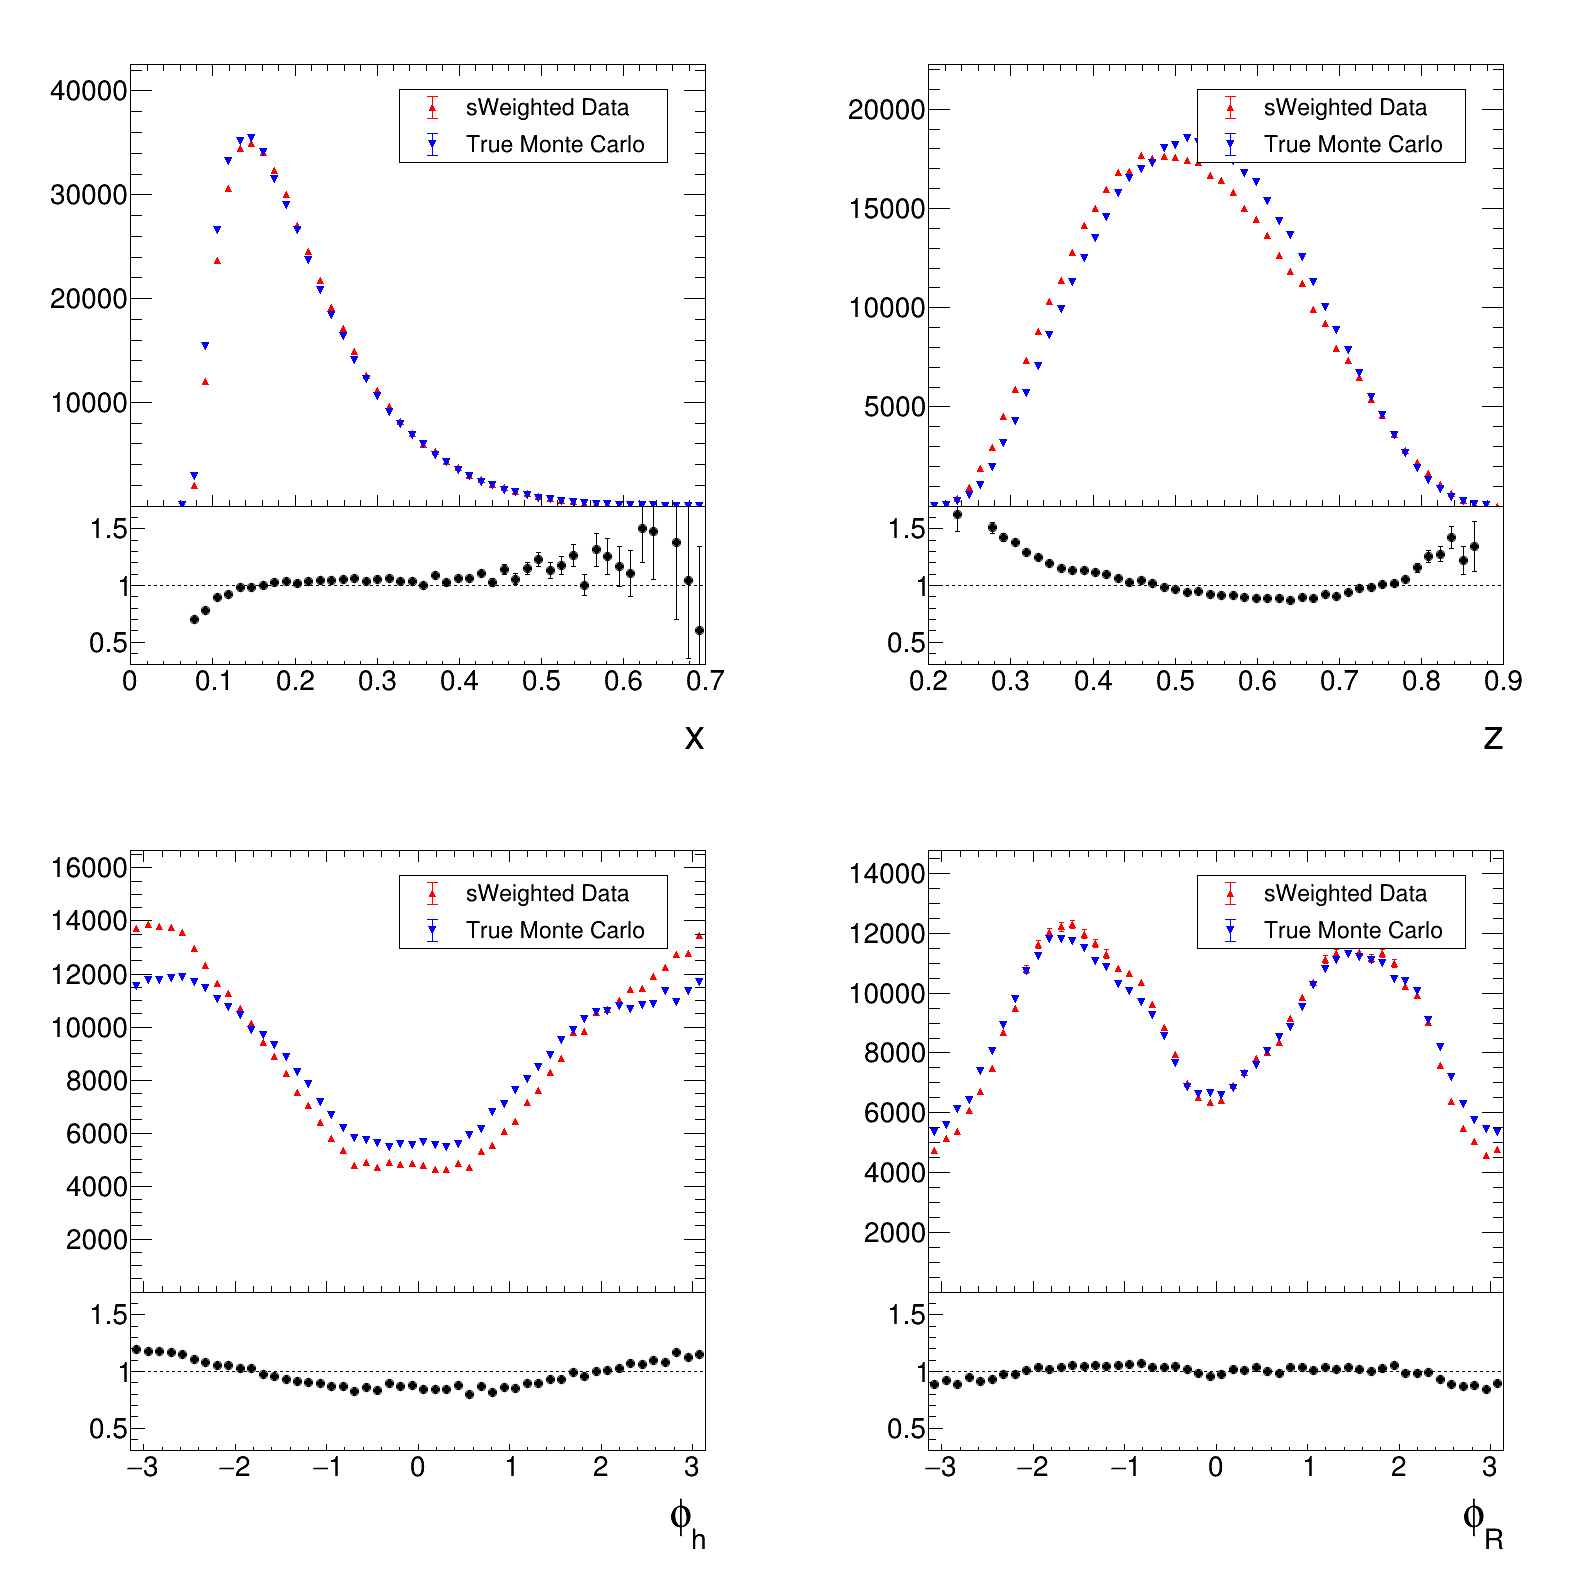

In [11]:
main_canvas = ROOT.TCanvas("cc","cc",1600,1600)
main_canvas.Divide(2,2)

canvas1 = canvas_with_ratio("x", "x", 0, 0.7, 50)
canvas2 = canvas_with_ratio("z", "z", 0.2, 0.9, 50)
canvas3 = canvas_with_ratio("phi_h", "#phi_{h}", -3.1415, 3.1415, 50)
canvas4 = canvas_with_ratio("phi_R0", "#phi_{R}", -3.1415, 3.1415, 50)

for ic, canvas in enumerate([canvas1,canvas2,canvas3,canvas4]):
    main_canvas.cd(ic+1)
    canvas.DrawClonePad()
main_canvas.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


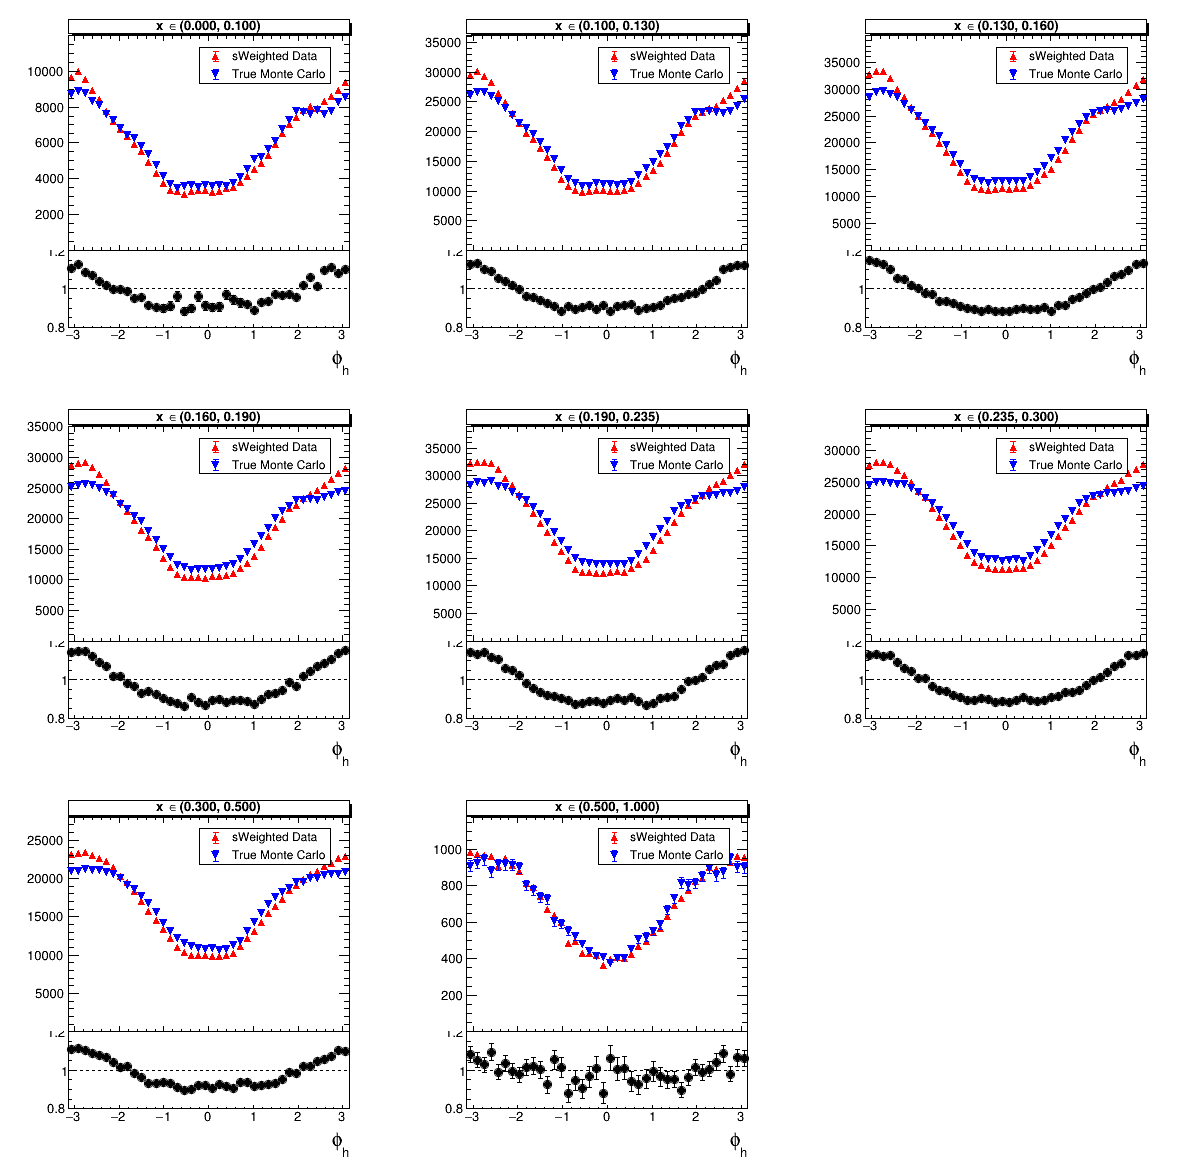

In [12]:
# Define the parameters for your histograms
branch_name = "phi_h"
xtitle = "#phi_{h}"
xmin, xmax = -3.1415,3.1415
nbins = 40

# Ratio y scale
ratio_y_scale = [0.8,1.2]

# Define the cut variable and the bins
index = 0
dimension_names, bin_edges = get_binning_structure(index)
cut_variable = dimension_names[0]
cut_bins = bin_edges[0]

# Number of cuts
n_cuts = len(cut_bins) - 1
n_rows = int(np.ceil(n_cuts/3))
# Create the grid canvas
grid_canvas = ROOT.TCanvas("grid_canvas", "Grid of Histograms", 1200, 400*n_rows)
grid_canvas.Divide(3,n_rows)   # 3 columns and n_cuts rows
cc=[]
pad_list=[]
do_grid_canvas(branch_name, xtitle, xmin, xmax, nbins, cut_variable, cut_bins, ratio_y_scale)

for i in range(n_cuts):
    grid_canvas.cd(i+1)
    try:
        cc[i].DrawClonePad()
    except:
        continue # Empty pad
    pad_list[i].Draw()
    
# Draw the grid canvas
grid_canvas.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: grid_canvas
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


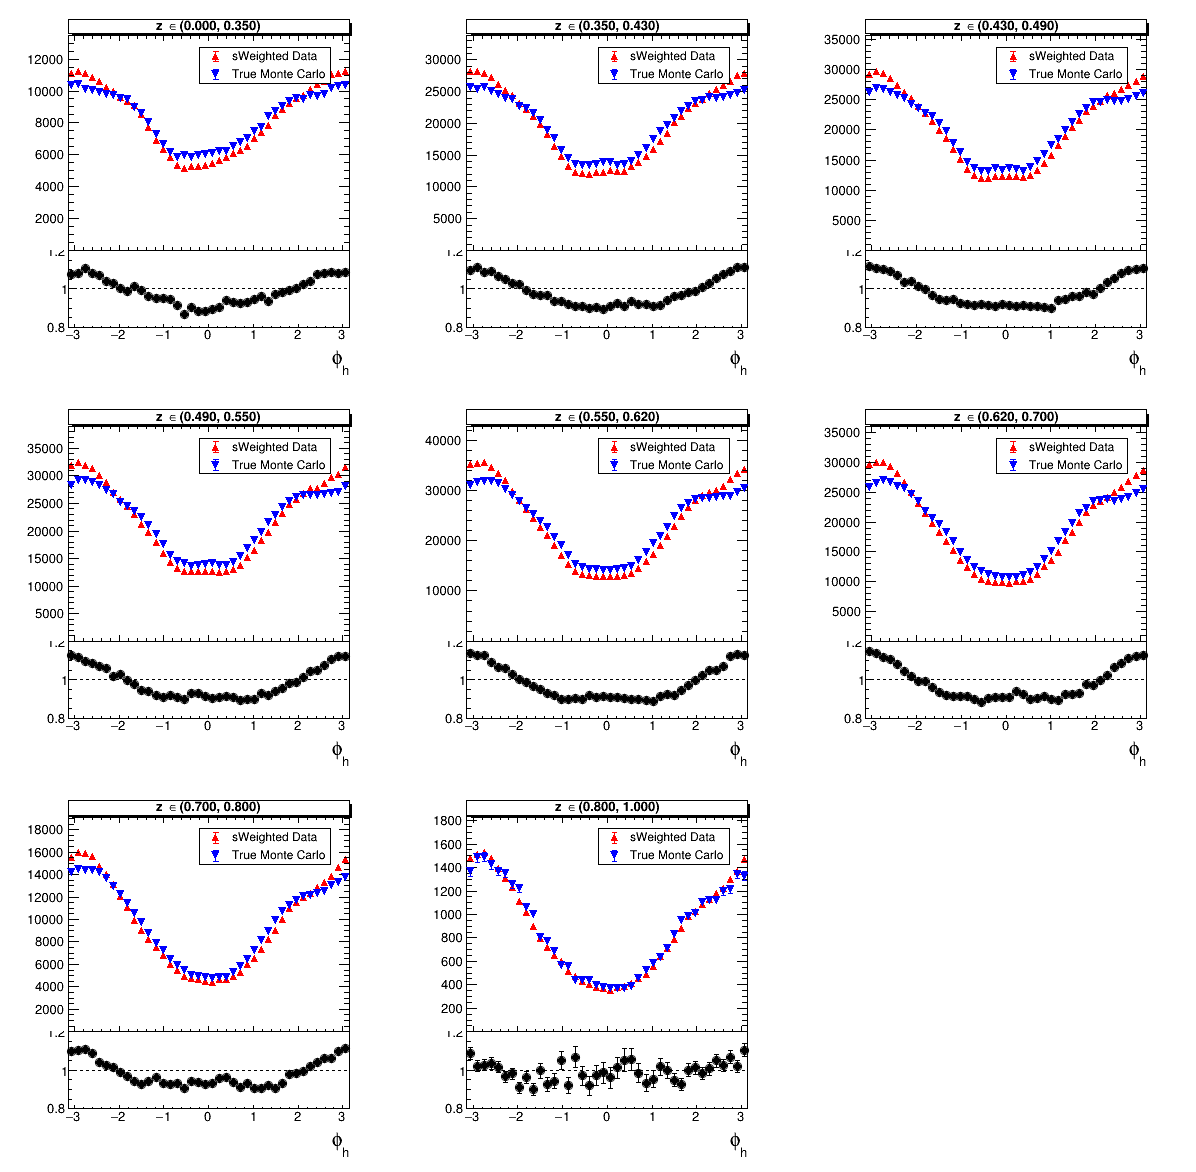

In [16]:
# Define the parameters for your histograms
branch_name = "phi_h"
xtitle = "#phi_{h}"
xmin, xmax = -3.1415,3.1415
nbins = 40

# Ratio y scale
ratio_y_scale = [0.8,1.2]

# Define the cut variable and the bins
index = 1
dimension_names, bin_edges = get_binning_structure(index)
cut_variable = dimension_names[0]
cut_bins = bin_edges[0]

# Number of cuts
n_cuts = len(cut_bins) - 1
n_rows = int(np.ceil(n_cuts/3))
# Create the grid canvas
grid_canvas = ROOT.TCanvas("grid_canvas", "Grid of Histograms", 1200, 400*n_rows)
grid_canvas.Divide(3,n_rows)   # 3 columns and n_cuts rows
cc=[]
pad_list=[]
do_grid_canvas(branch_name, xtitle, xmin, xmax, nbins, cut_variable, cut_bins, ratio_y_scale)

for i in range(n_cuts):
    grid_canvas.cd(i+1)
    try:
        cc[i].DrawClonePad()
    except:
        continue # Empty pad
    pad_list[i].Draw()
    
# Draw the grid canvas
grid_canvas.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: grid_canvas
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


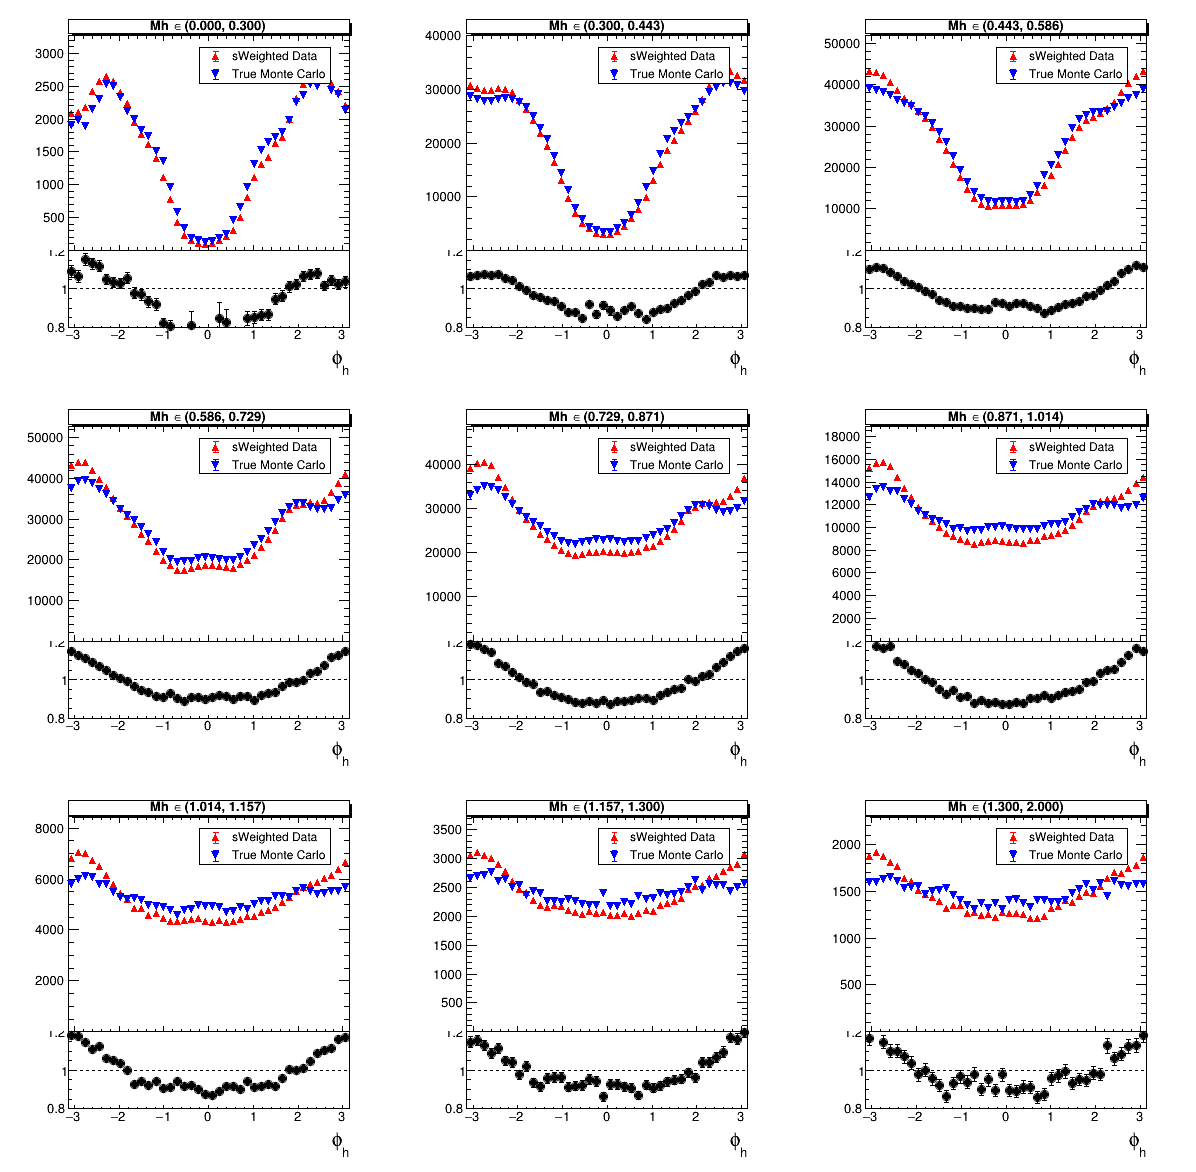

In [17]:
# Define the parameters for your histograms
branch_name = "phi_h"
xtitle = "#phi_{h}"
xmin, xmax = -3.1415,3.1415
nbins = 40

# Ratio y scale
ratio_y_scale = [0.8,1.2]

# Define the cut variable and the bins
index = 2
dimension_names, bin_edges = get_binning_structure(index)
cut_variable = dimension_names[0]
cut_bins = bin_edges[0]

# Number of cuts
n_cuts = len(cut_bins) - 1
n_rows = int(np.ceil(n_cuts/3))
# Create the grid canvas
grid_canvas = ROOT.TCanvas("grid_canvas", "Grid of Histograms", 1200, 400*n_rows)
grid_canvas.Divide(3,n_rows)   # 3 columns and n_cuts rows
cc=[]
pad_list=[]
do_grid_canvas(branch_name, xtitle, xmin, xmax, nbins, cut_variable, cut_bins, ratio_y_scale)

for i in range(n_cuts):
    grid_canvas.cd(i+1)
    try:
        cc[i].DrawClonePad()
    except:
        continue # Empty pad
    pad_list[i].Draw()
    
# Draw the grid canvas
grid_canvas.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


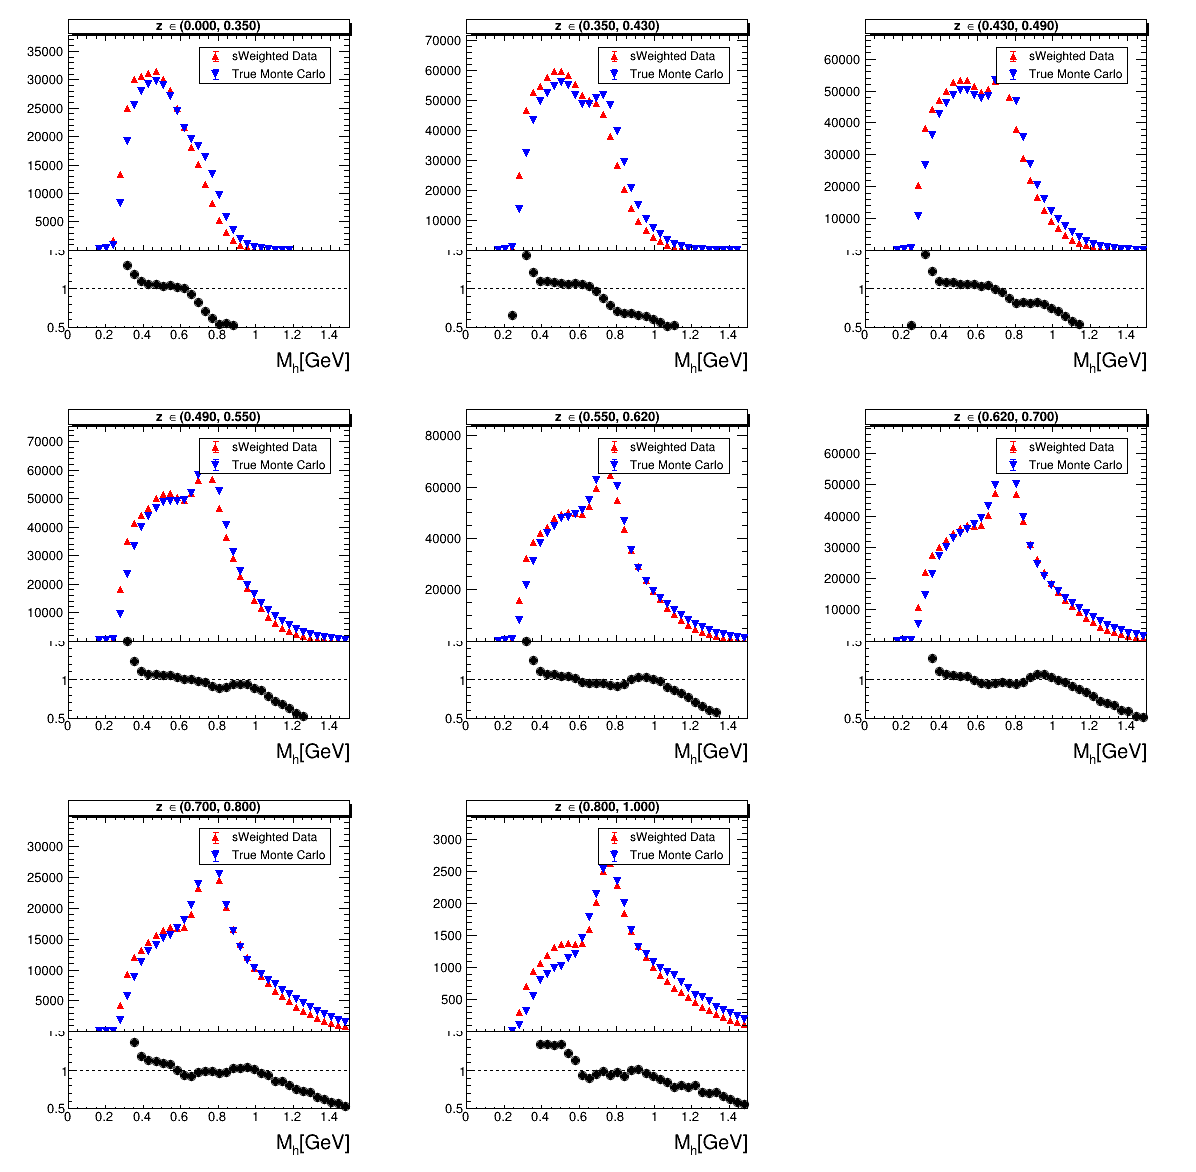

In [12]:
# Define the parameters for your histograms
branch_name = "Mh"
xtitle = "M_{h}[GeV]"
xmin, xmax = 0,1.5
nbins = 40

# Ratio y scale
ratio_y_scale = [0.5,1.5]

# Define the cut variable and the bins
index = 1
dimension_names, bin_edges = get_binning_structure(index)
cut_variable = dimension_names[0]
cut_bins = bin_edges[0]

# Number of cuts
n_cuts = len(cut_bins) - 1
n_rows = int(np.ceil(n_cuts/3))
# Create the grid canvas
grid_canvas = ROOT.TCanvas("grid_canvas", "Grid of Histograms", 1200, 400*n_rows)
grid_canvas.Divide(3,n_rows)   # 3 columns and n_cuts rows
cc=[]
pad_list=[]
do_grid_canvas(branch_name, xtitle, xmin, xmax, nbins, cut_variable, cut_bins, ratio_y_scale)

for i in range(n_cuts):
    grid_canvas.cd(i+1)
    try:
        cc[i].DrawClonePad()
    except:
        continue # Empty pad
    pad_list[i].Draw()
    
# Draw the grid canvas
grid_canvas.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: grid_canvas
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


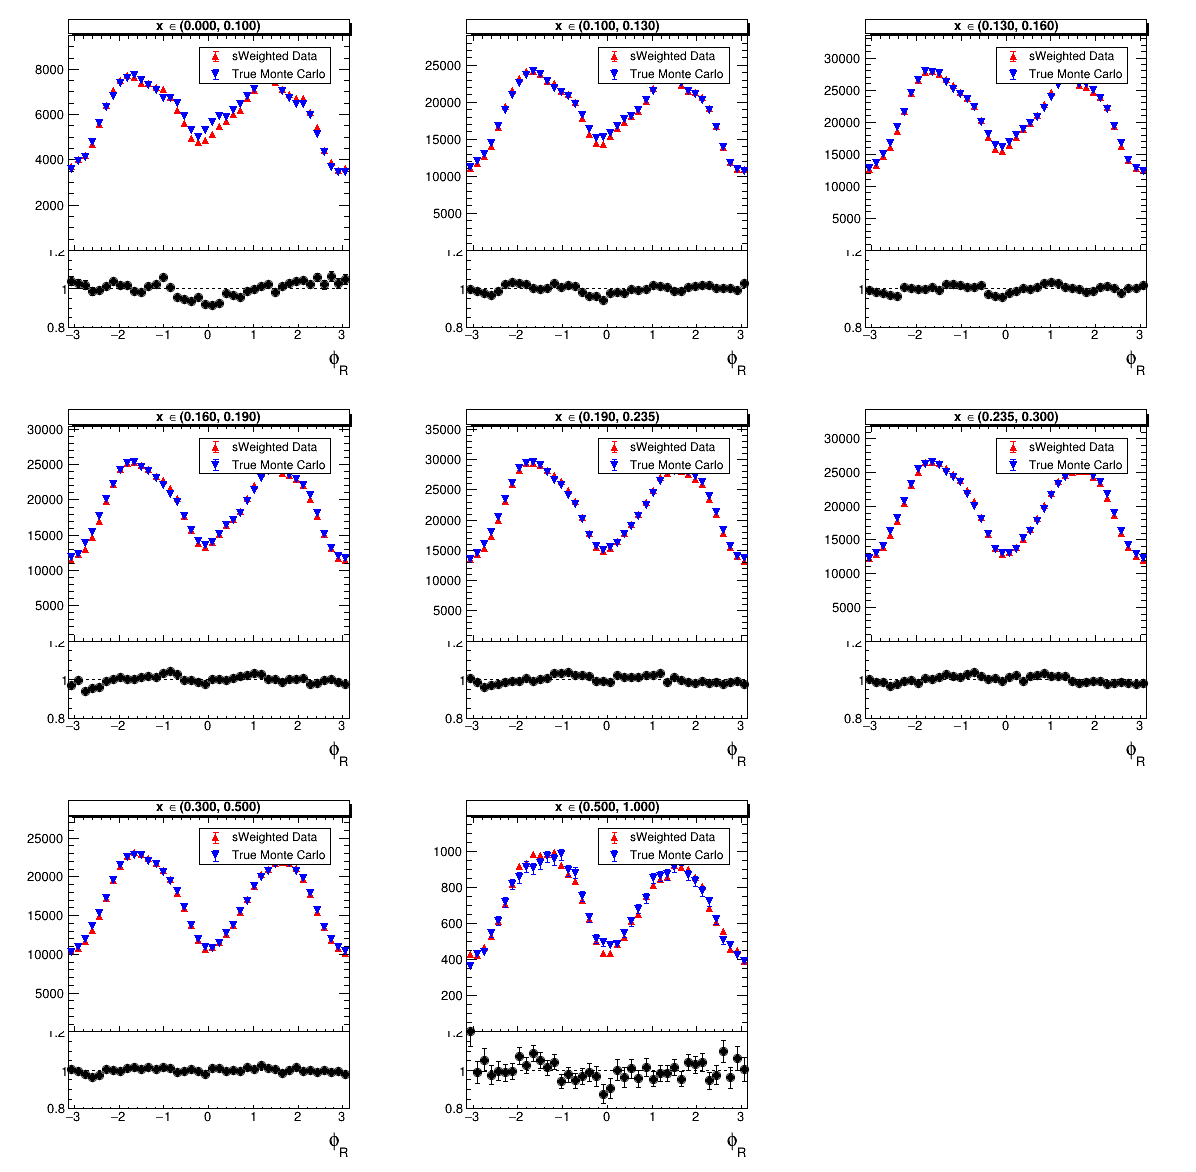

In [14]:
# Define the parameters for your histograms
branch_name = "phi_R0"
xtitle = "#phi_{R}"
xmin, xmax = -3.1415,3.1415
nbins = 40

# Ratio y scale
ratio_y_scale = [0.8,1.2]

# Define the cut variable and the bins
index = 0
dimension_names, bin_edges = get_binning_structure(index)
cut_variable = dimension_names[0]
cut_bins = bin_edges[0]
# Number of cuts
n_cuts = len(cut_bins) - 1
n_rows = int(np.ceil(n_cuts/3))
# Create the grid canvas
grid_canvas = ROOT.TCanvas("grid_canvas", "Grid of Histograms", 1200, 400*n_rows)
grid_canvas.Divide(3,n_rows)   # 3 columns and n_cuts rows
cc=[]
pad_list=[]
do_grid_canvas(branch_name, xtitle, xmin, xmax, nbins, cut_variable, cut_bins, ratio_y_scale)

for i in range(n_cuts):
    grid_canvas.cd(i+1)
    try:
        cc[i].DrawClonePad()
    except:
        continue # Empty pad
    pad_list[i].Draw()
    
# Draw the grid canvas
grid_canvas.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: grid_canvas
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


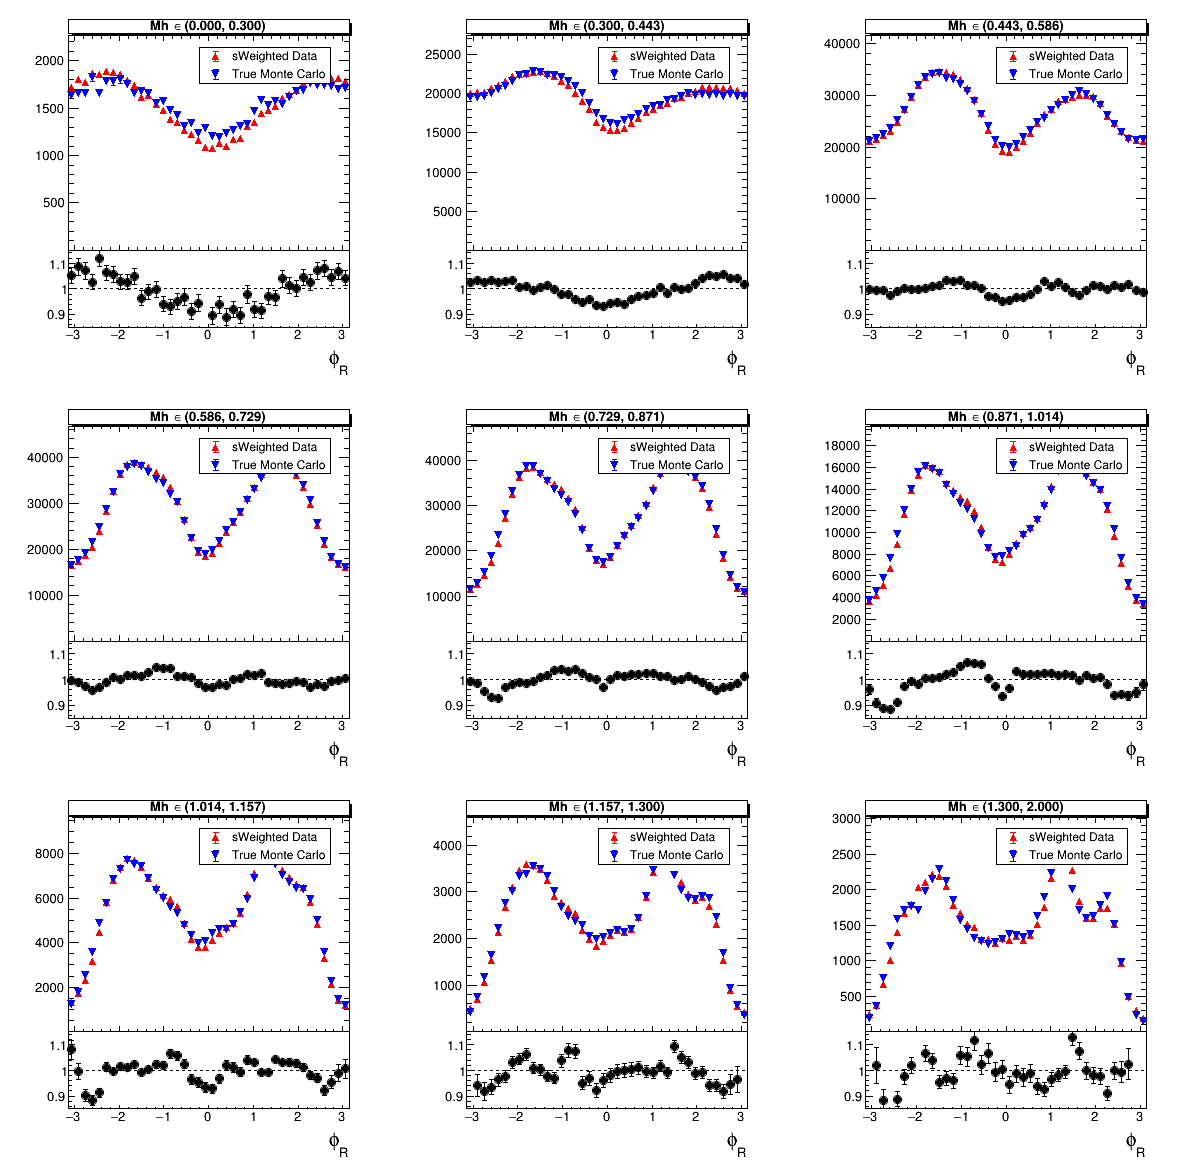

In [15]:
# Define the parameters for your histograms
branch_name = "phi_R0"
xtitle = "#phi_{R}"
xmin, xmax = -3.1415,3.1415
nbins = 40

# Ratio y scale
ratio_y_scale = [0.85,1.15]

# Define the cut variable and the bins
index = 2
dimension_names, bin_edges = get_binning_structure(index)
cut_variable = dimension_names[0]
cut_bins = bin_edges[0]
# Number of cuts
n_cuts = len(cut_bins) - 1
n_rows = int(np.ceil(n_cuts/3))
# Create the grid canvas
grid_canvas = ROOT.TCanvas("grid_canvas", "Grid of Histograms", 1200, 400*n_rows)
grid_canvas.Divide(3,n_rows)   # 3 columns and n_cuts rows
cc=[]
pad_list=[]
do_grid_canvas(branch_name, xtitle, xmin, xmax, nbins, cut_variable, cut_bins, ratio_y_scale)

for i in range(n_cuts):
    grid_canvas.cd(i+1)
    try:
        cc[i].DrawClonePad()
    except:
        continue # Empty pad
    pad_list[i].Draw()
    
# Draw the grid canvas
grid_canvas.Draw()

In [2]:
import os
from glob import glob
files = glob("../../projects/pipi0_paper_RGA_only/volatile/data/piplus_pi0/nSidis_RGA_503*.root")


In [ ]:
import os
from glob import glob
import ROOT
import copy
# Create a canvas for plotting
canvas = ROOT.TCanvas("canvas", "Histograms", 800, 600)

# Create a legend
legend = ROOT.TLegend(0.1, 0.7, 0.9, 0.9)
legend.SetNColumns(4)
# Define marker colors and styles
marker_colors = [ROOT.kBlack, ROOT.kRed, ROOT.kBlue, ROOT.kGreen, ROOT.kOrange, ROOT.kMagenta]
marker_styles = [ROOT.kFullCircle, ROOT.kFullSquare, ROOT.kFullTriangleUp, ROOT.kFullTriangleDown, ROOT.kFullDiamond]
Nmax=len(marker_colors)*len(marker_styles)
# Get the list of root files
files = glob("../../projects/pipi0_paper_RGA_only/volatile/data/piplus_pi0/nSidis_RGA_51*.root")

hists=[]
# Loop over the files
for i, file_path in enumerate(files):
    # Extract the number after "RGA" in the file's name
    number = int(os.path.basename(file_path).split("RGA_")[1][:4])
    
    # Open the root file
    root_file = ROOT.TFile(file_path)
    
    # Get the TTree
    tree = root_file.Get("dihadron_cuts")
    
    # Create a unique histogram name
    hist_name = f"hist_{number}"
    
    # Create a histogram
    hists.append(ROOT.TH1F(hist_name, f"Mh Histogram (RGA {number})", 50, 0.2, 1.5))

    # Set marker color and style
    hists[-1].SetMarkerColor(marker_colors[i % len(marker_colors)])
    hists[-1].SetMarkerStyle(marker_styles[i % len(marker_styles)])

    # Fill the histogram with data from the TTree
    tree.Draw(f"Mh >> {hist_name}","","goff")

    # Normalize the histogram to an integral of 1
    if(hists[-1].Integral()==0):
        continue

    hists[-1].Scale(1.0 / hists[-1].Integral())
    
    # Add the histogram to the legend
    legend.AddEntry(hists[-1], f"{number}({hists[-1].GetEntries():.2e})", "p")
    
    # Plot the histogram on the canvas
    if i == 0:
        hists[-1].Draw("P")
    else:
        hists[-1].Draw("P same")
    hists[-1].SetDirectory(0)
    hists[0].GetYaxis().SetRangeUser(0,0.07)
    ROOT.gStyle.SetOptStat(0)
    if(i-1==Nmax):
        break
# Draw the legend
legend.Draw()

# Update the canvas
canvas.Draw()



In [ ]:
import os
from glob import glob
import ROOT
import copy

# Define the maximum number of histograms per canvas
Nmax = 20

# Create a list to store canvases
canvas_list = []

# Sort the file list
files = sorted(glob("../../projects/pipi0_paper_RGA_only/volatile/data/piplus_pi0/nSidis_RGA_5*.root"))

# Create a canvas for plotting
canvas = ROOT.TCanvas("canvas", "Histograms", 800, 600)

# Create a legend
legend = ROOT.TLegend(0.1, 0.7, 0.9, 0.9)
legend.SetNColumns(4)

# Define marker colors and styles
marker_colors = [ROOT.kBlack, ROOT.kRed, ROOT.kBlue, ROOT.kGreen, ROOT.kOrange, ROOT.kMagenta]
marker_styles = [ROOT.kFullCircle, ROOT.kFullSquare, ROOT.kFullTriangleUp, ROOT.kFullTriangleDown, ROOT.kFullDiamond]

# Loop over the files
for i, file_path in enumerate(files):
    # Extract the number after "RGA" in the file's name
    number = int(os.path.basename(file_path).split("RGA_")[1][:4])
    
    # Open the root file
    root_file = ROOT.TFile(file_path)
    
    # Get the TTree
    tree = root_file.Get("dihadron_cuts")
    
    # Create a unique histogram name
    hist_name = f"hist_{number}"
    
    # Create a histogram
    hist = ROOT.TH1F(hist_name, f"Mh Histogram (RGA {number})", 50, 0.2, 1.5)

    # Set marker color and style
    hist.SetMarkerColor(marker_colors[i % len(marker_colors)])
    hist.SetMarkerStyle(marker_styles[i % len(marker_styles)])

    # Fill the histogram with data from the TTree
    tree.Draw(f"Mh >> {hist_name}", "", "goff",100)

    # Normalize the histogram to an integral of 1
    if hist.Integral() == 0:
        continue

    hist.Scale(1.0 / hist.Integral())
    
    # Add the histogram to the legend
    legend.AddEntry(hist, f"{number}({hist.GetEntries():.2e})", "p")
    
    # Plot the histogram on the canvas
    hist.Draw("P same")

    # Check if a new canvas needs to be created
    if (i + 1) % Nmax == 0 or i == len(files) - 1:
        # Save the current canvas to the list
        legend.Draw()
        canvas_list.append(copy.deepcopy(canvas))
        
        # Reset the canvas and legend for the next set of histograms
        canvas.Clear()
        legend.Clear()

# Draw the legend
legend.Draw()

# Update the canvas
canvas_list[0].Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


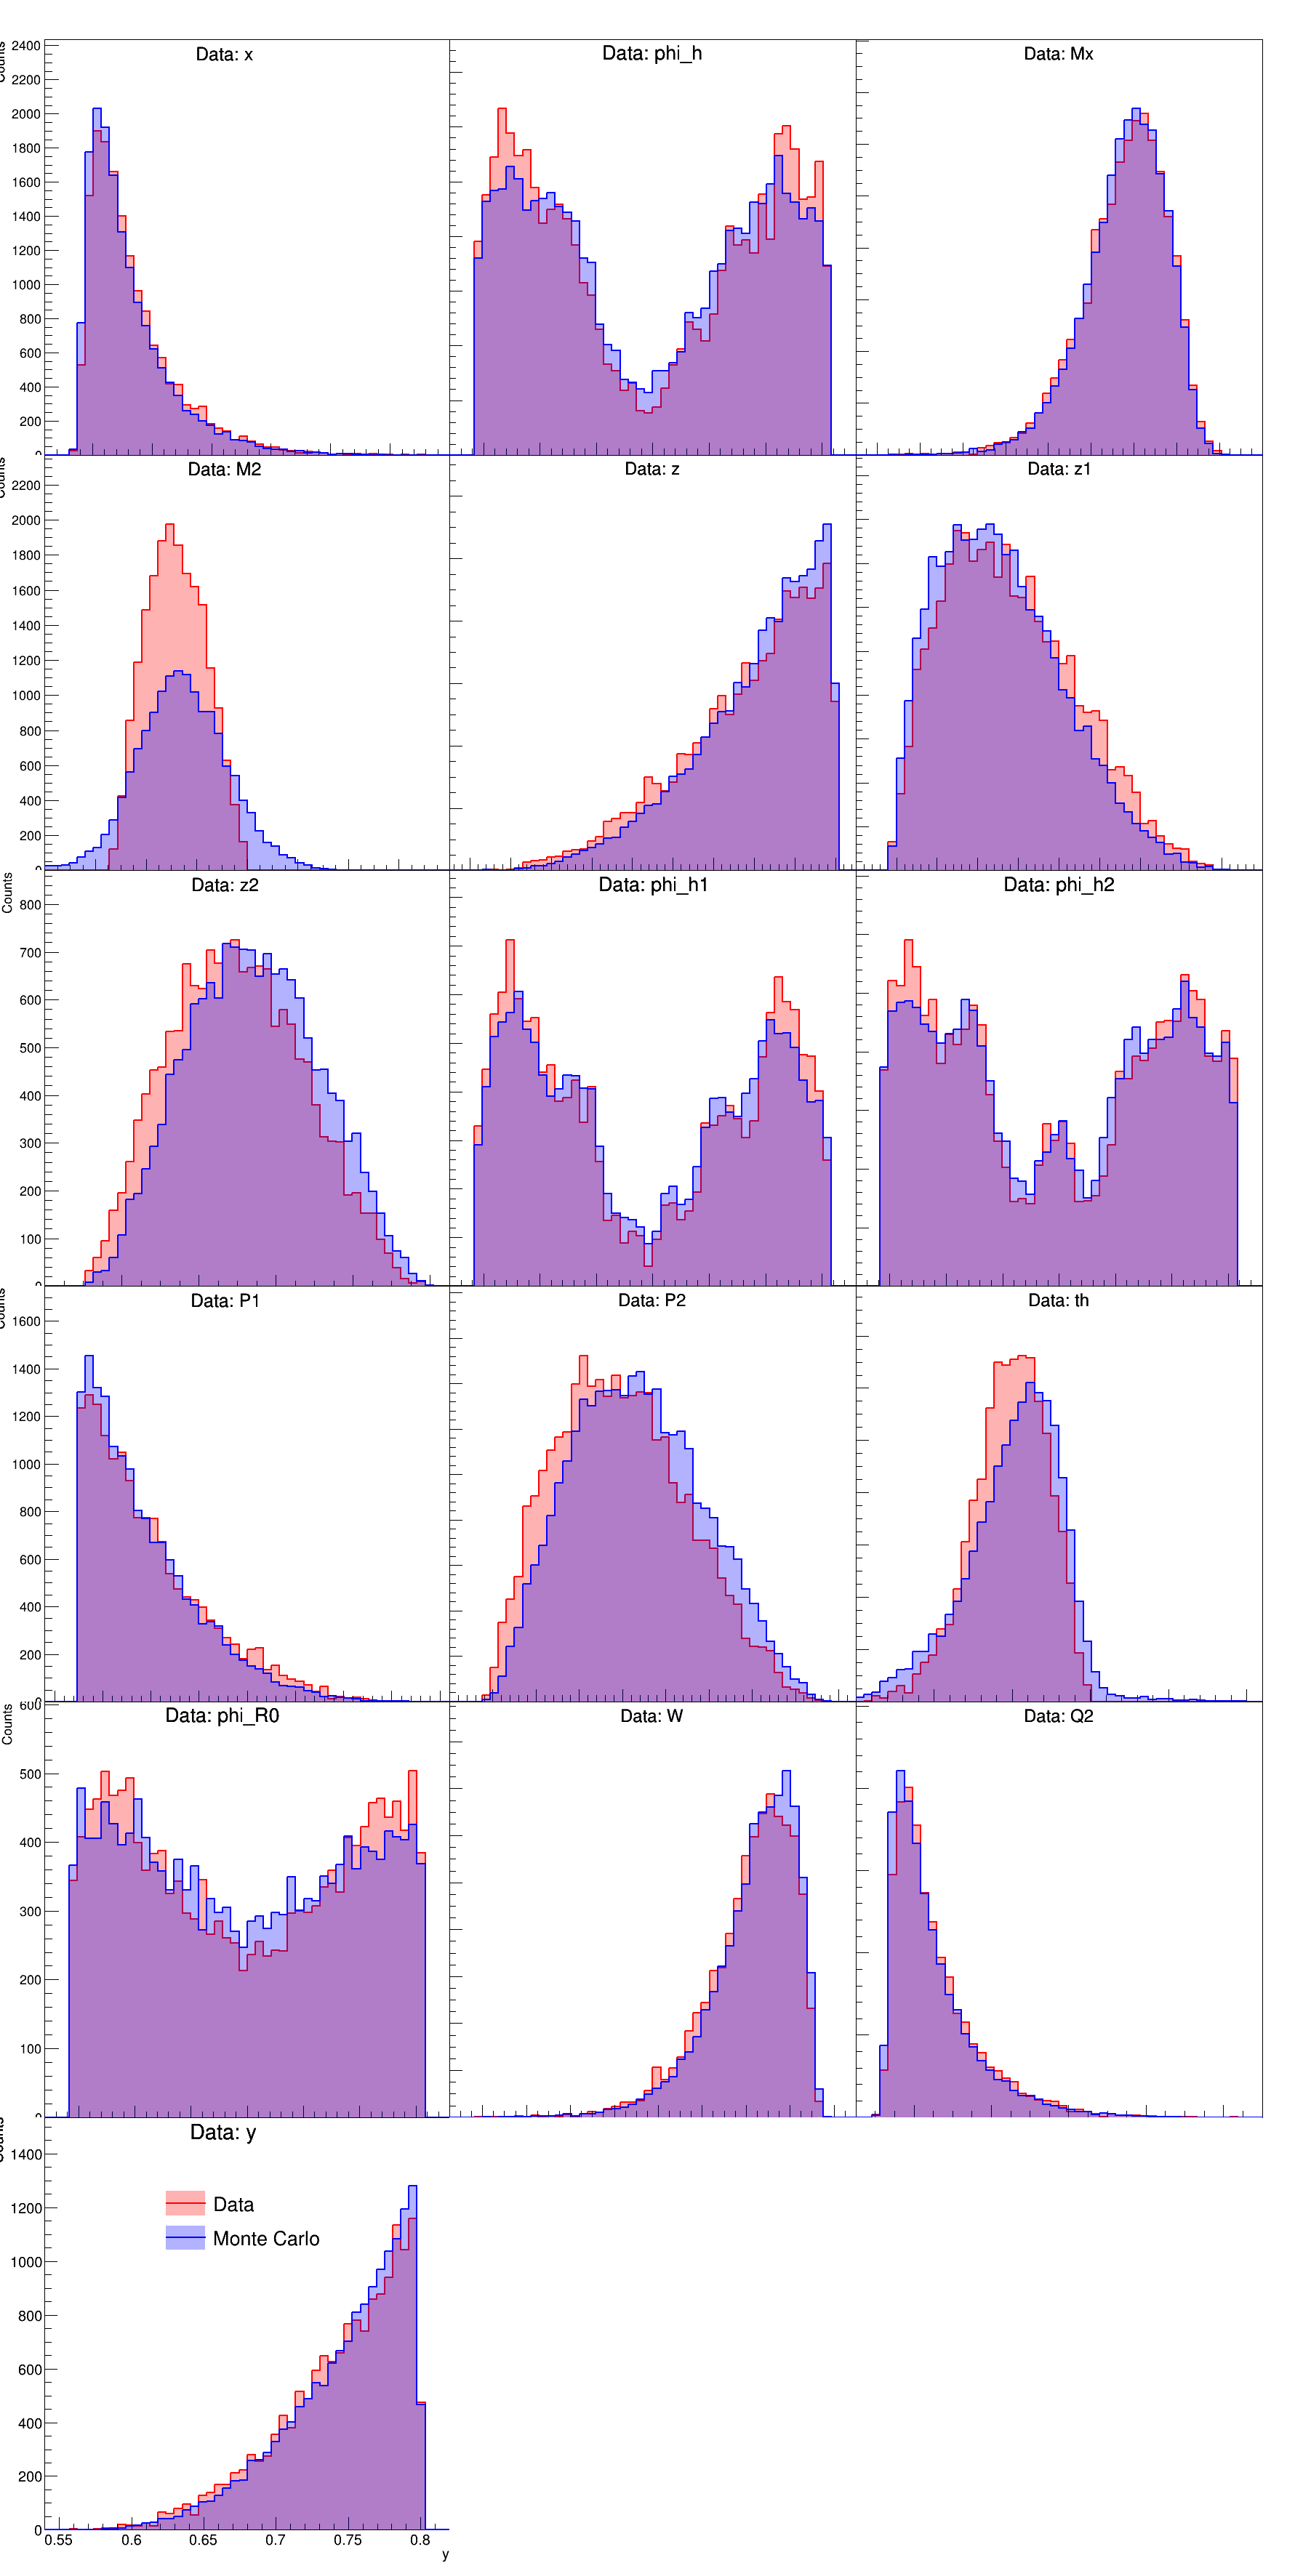

In [39]:
import ROOT
import copy 
import math

def compare_branches(tdata, tmc, branches, z_range=(0.2, 0.29), mh_range=(0, 0.4), N=int(1e8)):
    # Create a canvas
    n_columns = 3
    n_rows = math.ceil(len(branches) / n_columns)

    # Create a canvas
    c = ROOT.TCanvas("c", "Comparison", n_columns * 600, n_rows * 600)
    c.Divide(n_columns, n_rows,0,0)
    
    # Prepare the selection strings for the specific z and Mh ranges
    data_select = f"Signal*(z>{z_range[0]}&&z<{z_range[1]}&&Mh>{mh_range[0]}&&Mh<{mh_range[1]})"
    mc_select = f"trueparentpid_2==111&&(z>{z_range[0]}&&z<{z_range[1]}&&Mh>{mh_range[0]}&&Mh<{mh_range[1]})"

    # Loop over the TBranches
    for i, branch in enumerate(branches):
        c.cd(i+1)  # Select the pad
        
        # Draw the data histogram
        tdata.Draw(f"{branch}>>data_hist_{branch}(50)", data_select, "hist", N)
        data_hist = ROOT.gPad.GetPrimitive(f"data_hist_{branch}")
        data_hist.SetLineColor(ROOT.kRed)
        data_hist.SetLineWidth(2)
        data_hist.SetFillColorAlpha(ROOT.kRed, 0.3)
        data_hist.SetTitle(f"Data: {branch}")
        data_hist.GetXaxis().SetTitle(branch)
        data_hist.GetYaxis().SetTitle("Counts")
        data_hist.SetStats(False)

        # Draw the MC histogram
        tmc.Draw(f"{branch}>>mc_hist_{branch}(50)", mc_select, "hist same", N)
        mc_hist = ROOT.gPad.GetPrimitive(f"mc_hist_{branch}")
        mc_hist.SetLineColor(ROOT.kBlue)
        mc_hist.SetLineWidth(2)
        mc_hist.SetFillColorAlpha(ROOT.kBlue, 0.3)
        mc_hist.SetTitle(f"Monte Carlo: {branch}")
        mc_hist.SetStats(False)
        
        # Draw the legend
        legend = ROOT.TLegend(0.35, 0.7, 0.85, 0.85)
        legend.AddEntry(data_hist, "Data", "lf")
        legend.AddEntry(mc_hist, "Monte Carlo", "lf")
        legend.SetBorderSize(0)
        legend.Draw()

        # Rescale the data histogram
        data_hist.Scale(mc_hist.Integral()/data_hist.Integral())
        ymax = max(data_hist.GetMaximum(), mc_hist.GetMaximum())
        data_hist.GetYaxis().SetRangeUser(0, ymax*1.2)
    
    # Draw the canvas
    return copy.deepcopy(c)

# Call the function with your TBranches, TTree tdata and tmc are not defined in the provided context.
branches = ['x',"phi_h","Mx","M2","z","z1","z2","phi_h1","phi_h2","P1","P2","th","phi_R0","W","Q2","y"]  # replace with your TBranches
c= compare_branches(tdata, tmc, branches)
c.Draw()

In [1]:
import ROOT

Welcome to JupyROOT 6.22/06


# Both Data and Monte Carlo sPlot

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


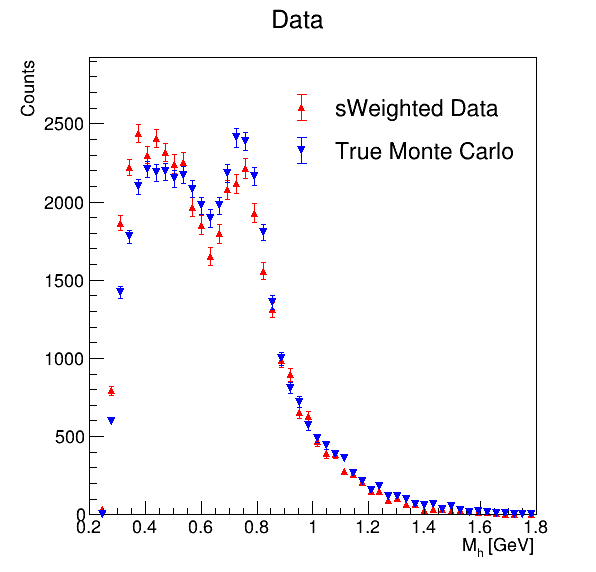

In [23]:
import ROOT

tfile1 = ROOT.TFile(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/clas12_dihadrons/projects/pipi0_paper_RGA_only/asym/MC_RGA_inbending/precut/{dihadron_str}/Mh/AZI/outsPlotBins/DataWeightedTree.root")
tfile2 = ROOT.TFile(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/clas12_dihadrons/projects/pipi0_paper_RGA_only/asym/Fall2018_RGA_inbending/precut/{dihadron_str}/Mh/AZI/outsPlotBins/DataWeightedTree.root")

tmc=tfile1.Get("dihadron_cuts") # Monte Carlo TTree
tdata=tfile2.Get("dihadron_cuts") # Data TTree

# Create a canvas
c = ROOT.TCanvas("c", "Histograms", 600, 600)

# Define the number of events
N = int(1e5)

# Draw the data histogram
tdata.Draw("Mh>>data_hist(50, 0.2, 1.8)", "Signal", "E1",N)
data_hist = ROOT.gPad.GetPrimitive("data_hist")
data_hist.SetMarkerColor(ROOT.kRed)
data_hist.SetLineColor(ROOT.kRed)
data_hist.SetMarkerStyle(22)
ROOT.gStyle.SetErrorX(0)
data_hist.GetXaxis().SetTitle("M_{h} [GeV]")
data_hist.GetYaxis().SetTitle("Counts")
data_hist.SetStats(False)
ROOT.gPad.SetLeftMargin(0.15)

# Draw the MC histogram
tmc.Draw("Mh>>mc_hist(50, 0.2, 1.8)", "Signal", "E1 same", N)
mc_hist = ROOT.gPad.GetPrimitive("mc_hist")
mc_hist.SetMarkerColor(ROOT.kBlue)
mc_hist.SetLineColor(ROOT.kBlue)
mc_hist.SetMarkerStyle(23)
ROOT.gStyle.SetErrorX(0)
mc_hist.GetXaxis().SetTitle("M_{h} [GeV]")
mc_hist.GetYaxis().SetTitle("Counts")
mc_hist.SetStats(False)
ROOT.gPad.SetLeftMargin(0.15)

# Draw the legend
legend = ROOT.TLegend(0.45, 0.7, 0.9, 0.85)
legend.AddEntry(data_hist, "sWeighted Data", "pe")
legend.AddEntry(mc_hist, "True Monte Carlo", "pe")
legend.SetBorderSize(0)
legend.Draw()

data_hist.Scale(mc_hist.Integral()/data_hist.Integral())
ymax = np.amax([data_hist.GetMaximum(),mc_hist.GetMaximum()])
data_hist.GetYaxis().SetRangeUser(0,ymax*1.2)

# Draw the canvas
c.Draw()
